In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


Read dataset


In [ ]:
dataset = pd.read_csv("output.csv")
dataset


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,eth.src,eth.dst,ip.version,ip.hdr_len,ip.tos,ip.id,...,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,srcport,dstport,length,checksum,quic
0,1,1.644570e+09,75,75,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20.0,NaN,0x58ed,...,0x1aaf,192.168.0.103,142.250.183.10,61.0,0x00,51876,443,41,0xfdc4,0
1,1,1.644570e+09,1292,1292,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20.0,NaN,0xa385,...,0x3e9c,192.168.0.103,142.250.67.196,1278.0,0x00,55366,443,1258,0x16bf,1
2,1,1.644570e+09,1292,1292,38:f9:d3:18:46:54,1c:3b:f3:ae:c6:f0,4,20.0,NaN,0xa432,...,0x3def,192.168.0.103,142.250.67.196,1278.0,0x00,55175,443,1258,0xf2d0,1
3,1,1.644570e+09,1292,1292,1c:3b:f3:ae:c6:f0,38:f9:d3:18:46:54,4,20.0,NaN,0x0000,...,0xa921,142.250.67.196,192.168.0.103,1278.0,0x00,443,55366,1258,0x6323,1
4,1,1.644570e+09,1292,1292,1c:3b:f3:ae:c6:f0,38:f9:d3:18:46:54,4,20.0,NaN,0x0000,...,0xa7a1,142.250.67.196,192.168.0.103,1278.0,0x80,443,55175,1258,0xcc50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98093,1,1.645097e+09,231,231,34:7d:f6:bb:05:80,7c:a9:6b:a6:de:ed,4,20.0,NaN,0x6787,...,0x0000,192.168.1.8,52.114.36.80,217.0,0x00,57074,443,20,0x1b3e,0
98094,1,1.645097e+09,54,54,7c:a9:6b:a6:de:ed,34:7d:f6:bb:05:80,4,20.0,NaN,0x3c63,...,0xb5fa,52.114.36.80,192.168.1.8,40.0,0x00,443,57074,20,0xf9ba,0
98095,1,1.645097e+09,75,75,34:7d:f6:bb:05:80,7c:a9:6b:a6:de:ed,4,20.0,NaN,0x4d10,...,0x0000,192.168.1.8,142.250.4.189,61.0,0x00,59163,443,41,0x55a2,1
98096,1,1.645097e+09,68,68,7c:a9:6b:a6:de:ed,34:7d:f6:bb:05:80,4,20.0,NaN,0x0000,...,0xeacf,142.250.4.189,192.168.1.8,54.0,0x80,443,59163,34,0xf0b0,1


Preprocess dataset

- Extract quic column data and remove from dataset.
- Remove the string related feilds.
- Remove empty feilds


In [ ]:
def preprocess(dataset):

    # 1. Remove the strings columnns from dataset.
    # eth.src, eth.dst, ip.src, ip.dst, ip.tos, ip.id, ip.flags, ip.checksum, ip.dsfield, checksum
    dataset.drop(
        [
            "eth.src",
            "eth.dst",
            "ip.src",
            "ip.dst",
            "ip.tos",
            "ip.id",
            "ip.flags",
            "ip.checksum",
            "ip.dsfield",
            "checksum",
        ],
        axis=1,
        inplace=True,
    )

    # 2. Remove the invalid rows ie axis=0 from the dataset.
    dataset.dropna(axis=0, inplace=True)

    # 3. After deleting the rows, reset the index column and delete it.
    dataset = dataset.reset_index(drop=True)

    # 4. Get the result(quic) column values and remove dataset.
    targets = list(dataset["quic"].values)
    dataset.drop(dataset.columns[len(dataset.columns) - 1], axis=1, inplace=True)

    print(dataset.info())
    return dataset, targets


initial_size = dataset.size
clean_dataset, targets = preprocess(dataset)
final_size = clean_dataset.size

if clean_dataset.isnull().values.any():
    print("Failed to clean dataset. There are NaN/null values in dataset.")
    nan_cols = [i for i in clean_dataset.columns if clean_dataset[i].isnull().any()]
    print("Columns with null values: ", *nan_cols)
    exit(1)


print(
    "\nDataset size: {0} = {1}, Cleaned dataset size: {2} = {3}, Percentage: {2}%".format(
        dataset.shape,
        initial_size,
        clean_dataset.shape,
        final_size,
        round(100 - (final_size / initial_size) * 100, 2),
    )
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98085 entries, 0 to 98084
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frame.encap_type  98085 non-null  int64  
 1   frame.time_epoch  98085 non-null  float64
 2   frame.len         98085 non-null  int64  
 3   frame.cap_len     98085 non-null  int64  
 4   ip.version        98085 non-null  int64  
 5   ip.hdr_len        98085 non-null  float64
 6   ip.flags.rb       98085 non-null  float64
 7   ip.flags.df       98085 non-null  float64
 8   ip.flags.mf       98085 non-null  float64
 9   ip.frag_offset    98085 non-null  float64
 10  ip.ttl            98085 non-null  float64
 11  ip.proto          98085 non-null  float64
 12  ip.len            98085 non-null  float64
 13  srcport           98085 non-null  int64  
 14  dstport           98085 non-null  int64  
 15  length            98085 non-null  int64  
dtypes: float64(9), int64(7)
memory usage: 12

Split train and test


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    clean_dataset, targets, test_size=0.20, random_state=7, shuffle=True
)

clean_dataset.reset_index(drop=True, inplace=True)
clean_dataset.to_csv("cleaned-dataset.csv")
clean_dataset


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,ip.version,ip.hdr_len,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.len,srcport,dstport,length
0,1,1.644570e+09,75,75,4,20.0,0.0,0.0,0.0,0.0,64.0,17.0,61.0,51876,443,41
1,1,1.644570e+09,1292,1292,4,20.0,0.0,0.0,0.0,0.0,64.0,17.0,1278.0,55366,443,1258
2,1,1.644570e+09,1292,1292,4,20.0,0.0,0.0,0.0,0.0,64.0,17.0,1278.0,55175,443,1258
3,1,1.644570e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,57.0,17.0,1278.0,443,55366,1258
4,1,1.644570e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,1278.0,443,55175,1258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98080,1,1.645097e+09,231,231,4,20.0,0.0,1.0,0.0,0.0,128.0,6.0,217.0,57074,443,20
98081,1,1.645097e+09,54,54,4,20.0,0.0,1.0,0.0,0.0,110.0,6.0,40.0,443,57074,20
98082,1,1.645097e+09,75,75,4,20.0,0.0,1.0,0.0,0.0,128.0,17.0,61.0,59163,443,41
98083,1,1.645097e+09,68,68,4,20.0,0.0,1.0,0.0,0.0,58.0,17.0,54.0,443,59163,34


Size and Train data colunmns


In [ ]:
print("Size of test: {0}, {1}".format(len(X_test), len(Y_test)))
print("Size of train: {0}, {1}".format(len(X_train), len(Y_train)))

X_train


Size of test: 19617, 19617
Size of train: 78468, 78468


,frame.encap_type,frame.time_epoch,frame.len,frame.cap_len,ip.version,ip.hdr_len,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.len,srcport,dstport,length
549,1,1.644570e+09,66,66,4,20.0,0.0,1.0,0.0,0.0,64.0,6.0,52.0,62104,443,32
40152,1,1.645096e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,121.0,17.0,1278.0,443,64286,1258
70837,1,1.645096e+09,103,103,4,20.0,0.0,1.0,0.0,0.0,255.0,17.0,89.0,5353,5353,69
9302,1,1.645096e+09,1292,1292,4,20.0,0.0,1.0,0.0,0.0,121.0,17.0,1278.0,443,53871,1258
57423,1,1.645096e+09,1274,1274,4,20.0,0.0,1.0,0.0,0.0,87.0,17.0,1260.0,443,64702,1240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53459,1,1.645096e+09,1274,1274,4,20.0,0.0,1.0,0.0,0.0,90.0,17.0,1260.0,443,63733,1240
10742,1,1.645096e+09,75,75,4,20.0,0.0,1.0,0.0,0.0,128.0,17.0,61.0,53501,443,41
49689,1,1.645096e+09,1274,1274,4,20.0,0.0,1.0,0.0,0.0,90.0,17.0,1260.0,443,63733,1240
58564,1,1.645096e+09,1274,1274,4,20.0,0.0,1.0,0.0,0.0,90.0,17.0,1260.0,443,59443,1240


Logistic Regression


In [ ]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Fitting the logistic regression algorithm to training dataset
model = LogisticRegression(random_state = 7)
clf = model.fit(X_train, Y_train)
predict = clf.predict(X_test)

print(classification_report(Y_test, predict))

print("Acuracy: {0}%".format(model.score(X_test,Y_test) * 100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4283
           1       0.78      1.00      0.88     15334

    accuracy                           0.78     19617
   macro avg       0.39      0.50      0.44     19617
weighted avg       0.61      0.78      0.69     19617

Acuracy: 78.16689605954019%
CPU times: user 248 ms, sys: 20.2 ms, total: 268 ms
Wall time: 151 ms


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN Algorithm


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

neigh = KNeighborsClassifier()
neigh.fit(X_train, Y_train)
predictions = neigh.predict(X_test)

print(classification_report(Y_test, predictions))

print("Acuracy: {0}%".format(neigh.score(X_test, Y_test) * 100))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4283
           1       1.00      1.00      1.00     15334

    accuracy                           1.00     19617
   macro avg       1.00      0.99      1.00     19617
weighted avg       1.00      1.00      1.00     19617

Acuracy: 99.70433807411938%


Decision tree


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

print("Acuracy: {0}%".format(model.score(X_test, Y_test) * 100))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4283
           1       1.00      1.00      1.00     15334

    accuracy                           1.00     19617
   macro avg       1.00      1.00      1.00     19617
weighted avg       1.00      1.00      1.00     19617

Acuracy: 99.8980476117653%


Random Forset


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
report = classification_report(Y_test, predictions)

print(report)

print("Acuracy: {0}%".format(model.score(X_test, Y_test) * 100))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4283
           1       1.00      1.00      1.00     15334

    accuracy                           1.00     19617
   macro avg       1.00      1.00      1.00     19617
weighted avg       1.00      1.00      1.00     19617

Acuracy: 99.88785237294184%


Feature importance for random forest


frame.encap_type    0.000000
frame.time_epoch    0.041570
frame.len           0.057809
frame.cap_len       0.055557
ip.version          0.000000
ip.hdr_len          0.000000
ip.flags.rb         0.000000
ip.flags.df         0.018272
ip.flags.mf         0.000000
ip.frag_offset      0.000000
ip.ttl              0.044705
ip.proto            0.309665
ip.len              0.059451
srcport             0.097999
dstport             0.098089
length              0.216884
dtype: float64


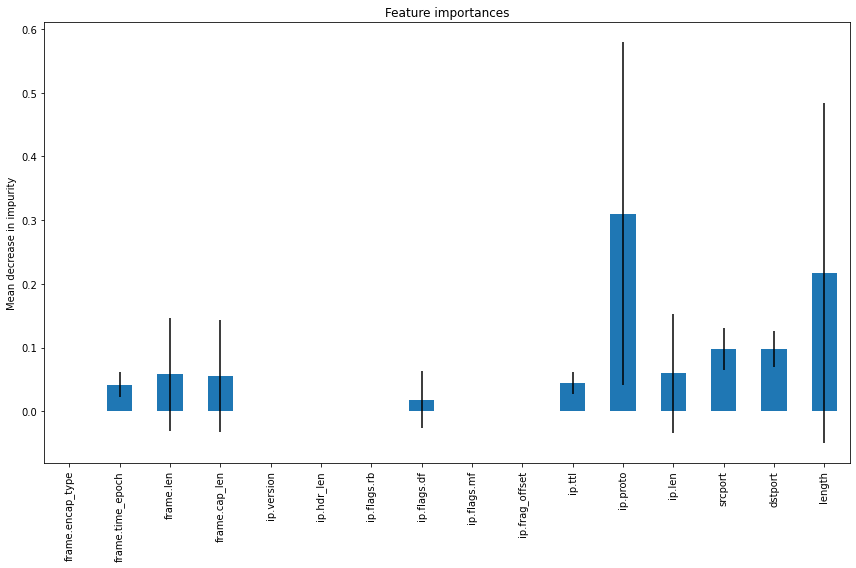

In [ ]:
import numpy as np
import pandas as pd

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

features = list(clean_dataset.columns)
classifier_importances = pd.Series(importances, index=features)
print(classifier_importances)

fig, ax = plt.subplots()
classifier_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(rect=(0, 0, 2, 2))
plt.show()


Plot classification.

pip3 install zip

Link: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report


[0.62, 1.0, 0.76]
[0.93, 0.93, 0.93]
[0.59, 0.97, 0.73]
[0.47, 0.92, 0.62]
[1.0, 0.16, 0.28]
plotMat: [[0.62, 1.0, 0.76], [0.93, 0.93, 0.93], [0.59, 0.97, 0.73], [0.47, 0.92, 0.62], [1.0, 0.16, 0.28]]
support: [66, 40, 67, 272, 413]


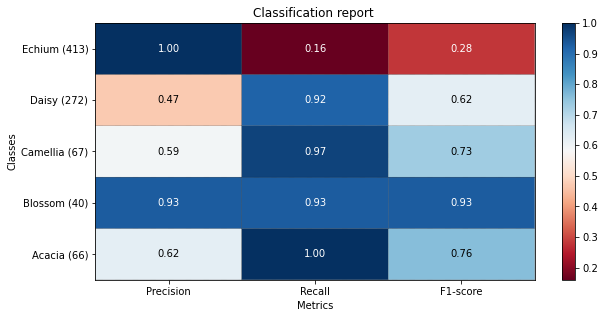

In [ ]:
# pip3 install zip

import numpy as np
import matplotlib.pyplot as plt


def show_values(pc, fmt="%.2f", **kw):
    """
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    """
    pc.update_scalarmappable()
    ax = pc.axes
    # ax = pc.axes# FOR LATEST MATPLOTLIB
    # Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    """
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    """
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i / inch for i in tupl[0])
    else:
        return tuple(i / inch for i in tupl)


def heatmap(
    AUC,
    title,
    xlabel,
    ylabel,
    xticklabels,
    yticklabels,
    figure_width=40,
    figure_height=20,
    correct_orientation=False,
    cmap="RdBu",
):
    """
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    """

    # Plot it out
    fig, ax = plt.subplots()
    # c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors="k", linestyle="dashed", linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    # ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim((0, AUC.shape[1]))

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    # fig.set_size_inches(cm2inch(40, 20))
    # fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))


def plot_classification_report(
    classification_report, title="Classification report ", cmap="RdBu"
):
    """
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    """
    lines = classification_report.split("\n")

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1 : len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print("plotMat: {0}".format(plotMat))
    print("support: {0}".format(support))

    xlabel = "Metrics"
    ylabel = "Classes"
    xticklabels = ["Precision", "Recall", "F1-score"]
    yticklabels = [
        "{0} ({1})".format(class_names[idx], sup) for idx, sup in enumerate(support)
    ]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(
        np.array(plotMat),
        title,
        xlabel,
        ylabel,
        xticklabels,
        yticklabels,
        figure_width,
        figure_height,
        correct_orientation,
        cmap=cmap,
    )


def main():
    sampleClassificationReport = """             precision    recall  f1-score   support

          Acacia       0.62      1.00      0.76        66
          Blossom       0.93      0.93      0.93        40
          Camellia       0.59      0.97      0.73        67
          Daisy       0.47      0.92      0.62       272
          Echium       1.00      0.16      0.28       413

        avg / total       0.77      0.57      0.49       858"""

    plot_classification_report(sampleClassificationReport)
    plt.show()
    # plt.savefig("classification_report.png", dpi=200, format="png", bbox_inches="tight")
    plt.close()


main()


Gradient boosting


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

print("Acuracy: {0}%".format(model.score(X_test, Y_test) * 100))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4283
           1       1.00      1.00      1.00     15334

    accuracy                           1.00     19617
   macro avg       1.00      1.00      1.00     19617
weighted avg       1.00      1.00      1.00     19617

Acuracy: 99.80119284294234%


Plot
